In [1]:
import os
import itertools
import shutil
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Reshape, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras

In [2]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=32)
    
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=32, shuffle=False)


Found 6360 images belonging to 5 classes.
Found 795 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


In [3]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
x = vgg16_model.layers[-2].output
output = Dense(units=5, activation='softmax')(x)
model = Model(inputs=vgg16_model.input, outputs=output)

for layer in model.layers[:-2]:
    layer.trainable = False
    
model.summary() 

print(len(model.layers))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [10]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=15,
            verbose=2
)

Epoch 1/15
199/199 - 1675s - loss: 0.7485 - accuracy: 0.7311 - val_loss: 0.4015 - val_accuracy: 0.8818
Epoch 2/15
199/199 - 1700s - loss: 0.3186 - accuracy: 0.9074 - val_loss: 0.2657 - val_accuracy: 0.9308
Epoch 3/15
199/199 - 1682s - loss: 0.2291 - accuracy: 0.9374 - val_loss: 0.2106 - val_accuracy: 0.9396
Epoch 4/15
199/199 - 1676s - loss: 0.1835 - accuracy: 0.9508 - val_loss: 0.1824 - val_accuracy: 0.9434
Epoch 5/15
199/199 - 1642s - loss: 0.1550 - accuracy: 0.9590 - val_loss: 0.1633 - val_accuracy: 0.9484
Epoch 6/15
199/199 - 1680s - loss: 0.1356 - accuracy: 0.9656 - val_loss: 0.1498 - val_accuracy: 0.9535
Epoch 7/15
199/199 - 1673s - loss: 0.1200 - accuracy: 0.9704 - val_loss: 0.1419 - val_accuracy: 0.9560
Epoch 8/15
199/199 - 1641s - loss: 0.1092 - accuracy: 0.9725 - val_loss: 0.1344 - val_accuracy: 0.9572
Epoch 9/15
199/199 - 1623s - loss: 0.0986 - accuracy: 0.9756 - val_loss: 0.1249 - val_accuracy: 0.9610
Epoch 10/15
199/199 - 1854s - loss: 0.0898 - accuracy: 0.9781 - val_loss:

In [11]:
model.save('models/model.h5')

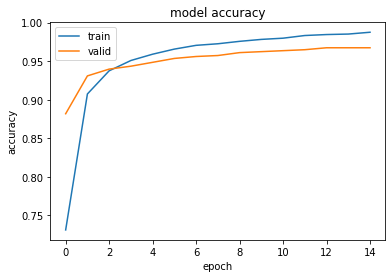

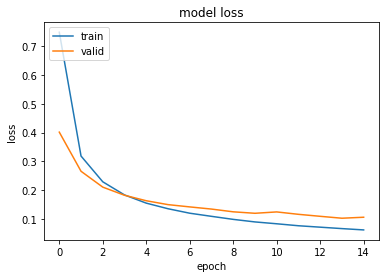

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [13]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [14]:
y_pred_bool = np.argmax(predictions, axis=1)

print(classification_report(test_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       160
           1       0.99      0.99      0.99       160
           2       0.95      0.97      0.96       160
           3       0.98      0.89      0.93       160
           4       0.98      0.98      0.98       160

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[158   0   1   1   0]
 [  0 159   0   1   0]
 [  1   0 156   1   2]
 [  7   2   7 143   1]
 [  3   0   0   0 157]]


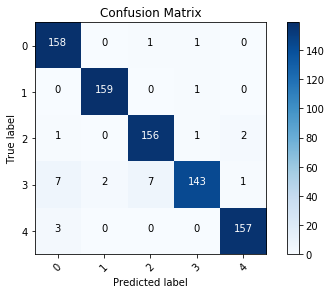

In [16]:
test_batches.class_indices

cm_plot_labels = ['0','1','2','3','4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')